In [1]:
import torch

from pina.problem import SpatialProblem, TimeDependentProblem
from pina.operators import laplacian, grad
from pina.geometry import CartesianDomain
from pina.solvers import *
from pina.trainer import Trainer
from pina.equation import Equation
from pina.equation.equation_factory import FixedValue
from pina import Condition, Plotter
from pytorch_lightning.loggers import TensorBoardLogger
from pina.model import FeedForward
from pina.callbacks import MetricTracker

In [2]:
class Helmholtz(SpatialProblem):
    output_variables = ['u']
    spatial_domain = CartesianDomain({'x':[-1,1],'y':[-1,1],'z':[-1,1]})
    def HH(input_,output_):
        a1 = 4
        a2 = 4
        a3 = 3
        u = output_.extract(['u'])
        x = input_.extract(['x'])
        y = input_.extract(['y'])
        z = input_.extract(['z'])
        nabla_u = laplacian(output_, input_, components=['u'], d=['x', 'y','z'])
        q = -u * ((a1*torch.pi)**2 + (a2*torch.pi)**2 + (a3*torch.pi)**2 - 1)
        return nabla_u + u - q
  
    def hh_sol(self,pts):
        a1 = 4
        a2 = 4
        a3 = 3
        x = pts.extract(['x'])
        y = pts.extract(['y'])
        z = pts.extract(['z'])
        return torch.sin(a1*torch.pi*x)*torch.sin(a2*torch.pi*y)*torch.sin(a3*torch.pi*z)
    truth_solution = hh_sol
    
    conditions = {
        'D': Condition(location=CartesianDomain({'x': [-1, 1], 'y': [-1, 1], 'z': [-1, 1]}), equation=Equation(HH)),
        'gamma1': Condition(location=CartesianDomain({'x': [-1, 1], 'y':  1, 'z': [-1, 1]}), equation=FixedValue(0.0)),
        'gamma2': Condition(location=CartesianDomain({'x': [-1, 1], 'y': -1, 'z': [-1, 1]}), equation=FixedValue(0.0)),
        'gamma3': Condition(location=CartesianDomain({'x':  1, 'y': [-1, 1], 'z': [-1, 1]}), equation=FixedValue(0.0)),
        'gamma4': Condition(location=CartesianDomain({'x': -1, 'y': [-1, 1], 'z': [-1, 1]}), equation=FixedValue(0.0)),
        'gamma5': Condition(location=CartesianDomain({'x': [-1, 1], 'y': [-1, 1], 'z': -1}), equation=FixedValue(0.0)),
        'gamma6': Condition(location=CartesianDomain({'x': [-1, 1], 'y': [-1, 1], 'z': 1}), equation=FixedValue(0.0)),
        
    }

In [3]:
problem = Helmholtz()

In [4]:
problem.discretise_domain(5000, 'random', locations=['D', 'gamma1', 'gamma2', 'gamma3', 'gamma4','gamma5','gamma6'])

In [5]:
model = FeedForward(
    layers=[64,64,64,64],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)
pinn = PINN(problem, model, optimizer_kwargs={'lr':0.001, 'weight_decay':1e-8})
gpinn = GPINN(problem, model, optimizer_kwargs={'lr':0.001, 'weight_decay':1e-8})
#causalpinn = CausalPINN(problem, model, optimizer_kwargs={'lr':0.001, 'weight_decay':1e-8})
sapinin = SAPINN(problem, model)


In [6]:
trainer = Trainer(pinn, max_epochs=30000, callbacks=[MetricTracker()], accelerator='gpu',enable_model_summary=False,) 
trainer.train()

/home/vemuri/anaconda3/envs/pina/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/vemuri/anaconda3/envs/pina/lib/python3.11/site ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/vemuri/anaconda3/envs/pina/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one o

Epoch 0:   0%|                                                                                               | 0/1 [00:00<?, ?it/s]

/home/vemuri/anaconda3/envs/pina/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 29999: 100%|█| 1/1 [00:00<00:00, 16.84it/s, v_num=2, gamma1_loss=2.34e-11, gamma2_loss=4.92e-11, gamma3_loss=2.91e-11, gamma4

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 29999: 100%|█| 1/1 [00:00<00:00,  5.90it/s, v_num=2, gamma1_loss=2.34e-11, gamma2_loss=4.92e-11, gamma3_loss=2.91e-11, gamma4


Plotting at z=0


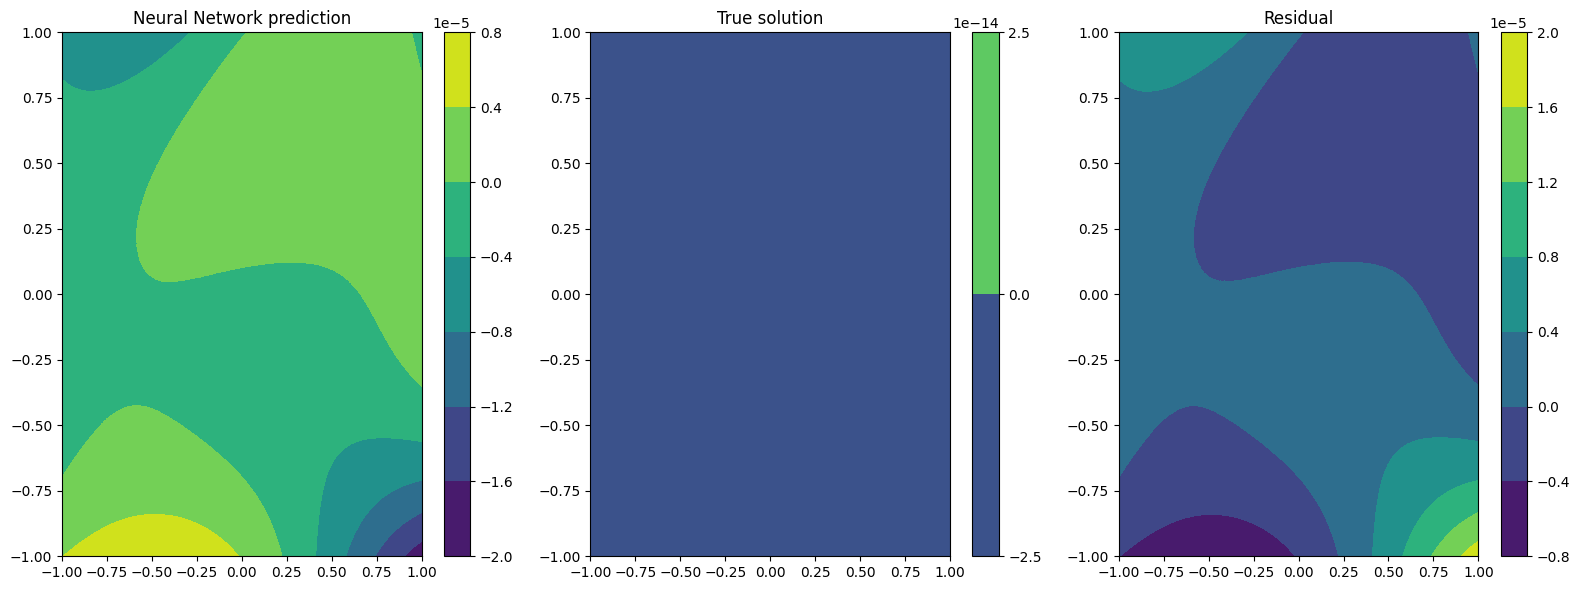

Plotting at z=0.5


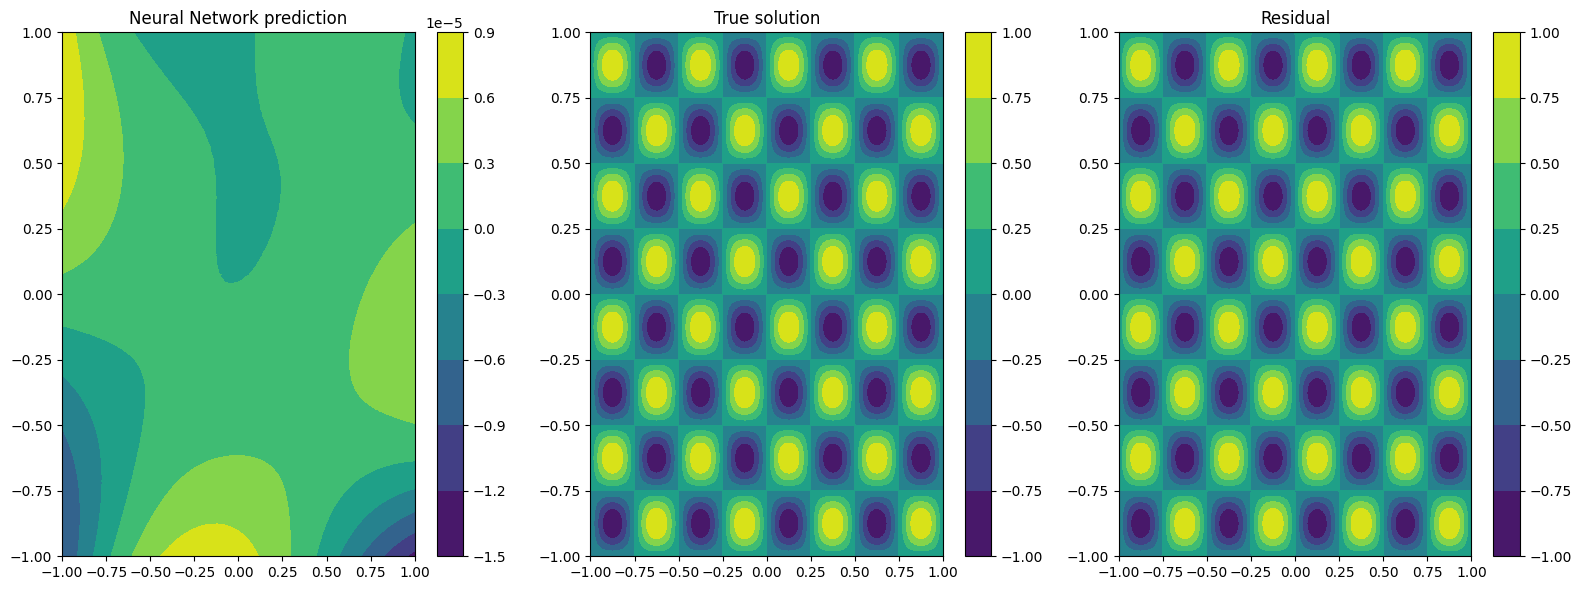

Plotting at z=0.5


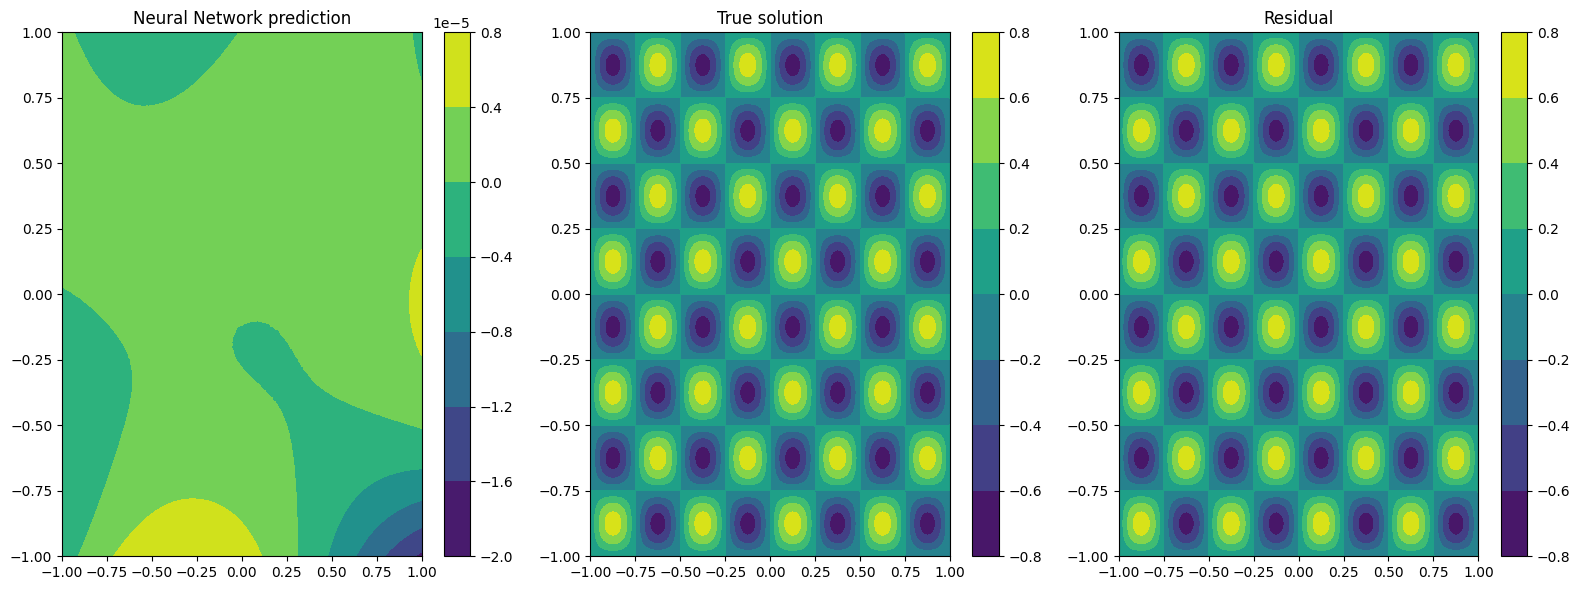

In [8]:
plotter = Plotter()

# plotting at fixed time t = 0.0
print('Plotting at z=0')
plotter.plot(pinn, fixed_variables={'z': 0.0})

# plotting at fixed time t = 0.5
print('Plotting at z=0.5')
plotter.plot(pinn, fixed_variables={'z':0.5})

# plotting at fixed time t = 1.
print('Plotting at z=0.5')
plotter.plot(pinn, fixed_variables={'z': 0.25})